# House Prices forecast

This notebook provides a simple framework for cleaning data, data engineering, model selection and visualization <br>
Dataset available at Kaggle and prepared by Durjpoy Chandra (https://www.kaggle.com/datasets/durjoychandrapaul/house-price-bangladesh)

In [26]:
# Basic libraries 
import pandas as pd
import numpy as np
from scipy import stats
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display='diagram')

# Models to be explored    
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

# Model-selection & metrics
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings("ignore")

## Explore the Data

In [2]:
filepath ='house_price_bd.csv'
df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             3865 non-null   object 
 1   Bedrooms          2864 non-null   float64
 2   Bathrooms         2864 non-null   float64
 3   Floor_no          3181 non-null   object 
 4   Occupancy_status  3766 non-null   object 
 5   Floor_area        3766 non-null   float64
 6   City              3865 non-null   object 
 7   Price_in_taka     3865 non-null   object 
 8   Location          3859 non-null   object 
dtypes: float64(3), object(6)
memory usage: 271.9+ KB


In [3]:
df.head()

,Title,Bedrooms,Bathrooms,Floor_no,Occupancy_status,Floor_area,City,Price_in_taka,Location
0,We Are Offering You A Very Spacious 1960 Sq Ft...,3.0,4.0,3,vacant,1960.0,dhaka,"৳39,000,000","Gulshan 1, Gulshan"
1,Valuable 1705 Square Feet Apartment Is Ready T...,3.0,3.0,1,vacant,1705.0,dhaka,"৳16,900,000","Lake Circus Road, Kalabagan"
2,1370 square feet apartment is ready to sale in...,3.0,3.0,6,vacant,1370.0,dhaka,"৳12,500,000","Shukrabad, Dhanmondi"
3,2125 Square Feet Apartment For Sale In Bashund...,3.0,3.0,4,vacant,2125.0,dhaka,"৳20,000,000","Block L, Bashundhara R-A"
4,Buy This 2687 Square Feet Flat In The Nice Are...,3.0,3.0,4,vacant,2687.0,dhaka,"৳47,500,000","Road No 25, Banani"


In [4]:
df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Bedrooms,2864.0,3.1,2.2,1.0,3.0,3.0,3.0,50.0
Bathrooms,2864.0,3.0,1.0,1.0,3.0,3.0,3.0,10.0
Floor_area,3766.0,1940.3,6024.9,84.0,1100.0,1380.0,1860.0,195840.0


In [5]:
df.isnull().sum()

Title                  0
Bedrooms            1001
Bathrooms           1001
Floor_no             684
Occupancy_status      99
Floor_area            99
City                   0
Price_in_taka          0
Location               6
dtype: int64

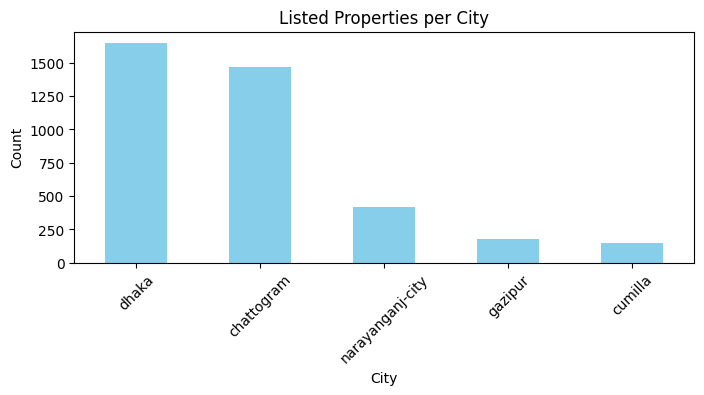

In [6]:
# Count the occurrences of each city
city_counts = df['City'].value_counts()

# Plot the bar chart using pandas
city_counts.plot(kind='bar', figsize=(8, 3), color='skyblue', title='Listed Properties per City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Occupancy_status
vacant      3763
occupied       3
Name: count, dtype: int64


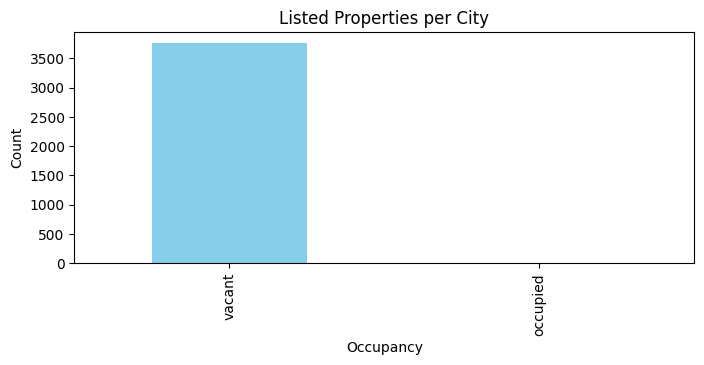

In [7]:
# Count the occurrences of each city
occupancy_counts = df['Occupancy_status'].value_counts()
print(occupancy_counts)
# Plot the bar chart using pandas
occupancy_counts.plot(kind='bar', figsize=(8, 3), color='skyblue', title='Listed Properties per City')
plt.xlabel('Occupancy')
plt.ylabel('Count')
plt.show()


Null values for bathrooms/bedrooms is a problem becuase they should be highly correlated with price

## Data Wrangling 

The floor numbers are stored as string/object datatypes and should be cast as integers

In [8]:

def floor(floor_value):
    if pd.isna(floor_value):
        return np.nan
    if re.search(r'\d+', floor_value):
        number = re.search(r'\d+', floor_value).group()
        return int(number)
    
    if '+' in floor_value:
        parts = floor_value.split('+')
        try:
            return int(parts[-1])
        except ValueError:
            return np.nan
        
    if ',' in floor_value or ' ' in floor_value:
        return np.nan
    return np.nan

df['Floor_no'] = df['Floor_no'].apply(floor)


In [9]:
# Replace currency symbols and commas, convert to float, and coerce errors
df['Price_in_taka'] = pd.to_numeric(df['Price_in_taka'].replace('[৳,]', '', regex=True), errors='coerce')

# Drop rows with missing target values
df = df.dropna(subset=['Price_in_taka'])
df = df.rename(columns={'Price_in_taka': 'Price'})

# Create a new colum for price per sq. foot
df['price_sqft'] = df['Price'] / df['Floor_area']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             3865 non-null   object 
 1   Bedrooms          2864 non-null   float64
 2   Bathrooms         2864 non-null   float64
 3   Floor_no          3175 non-null   float64
 4   Occupancy_status  3766 non-null   object 
 5   Floor_area        3766 non-null   float64
 6   City              3865 non-null   object 
 7   Price             3865 non-null   int64  
 8   Location          3859 non-null   object 
 9   price_sqft        3766 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 302.1+ KB


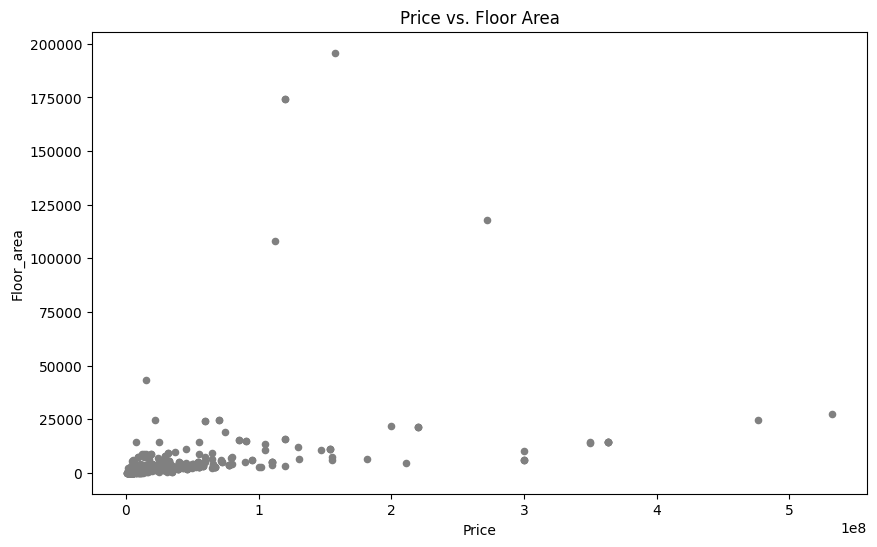

In [10]:
df.plot(kind='scatter', x='Price', y='Floor_area', figsize=(10, 6), color='grey', title='Price vs. Floor Area')
plt.show()

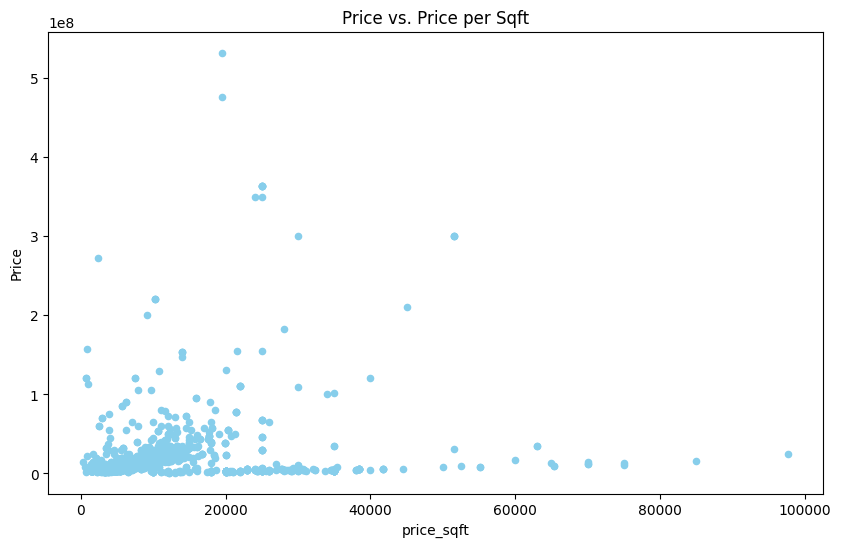

In [11]:
df.plot(kind='scatter', x='price_sqft', y='Price', figsize=(10, 6), color='skyblue', title='Price vs. Price per Sqft')
plt.show()

## Missing Values & Outliers 
The visualizations demonstrate that there a lot of outliers which require attention.  While it is possible to deal with missing values in the pipeline, for the purpose of this exercise, we will remove outliers before preprocessing. 

In [12]:
# numeric columns
num_attribs = ['Bedrooms', 'Bathrooms', 'Floor_area', 'Price', 'price_sqft']
df = df.dropna(subset = num_attribs).reset_index(drop = True)

In [13]:
# Check for missing/null values to be addressed in processing
is_NaN = df[num_attribs].isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[num_attribs][row_has_NaN]
print(rows_with_NaN)
df.info()

Empty DataFrame
Columns: [Bedrooms, Bathrooms, Floor_area, Price, price_sqft]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2864 non-null   object 
 1   Bedrooms          2864 non-null   float64
 2   Bathrooms         2864 non-null   float64
 3   Floor_no          2832 non-null   float64
 4   Occupancy_status  2864 non-null   object 
 5   Floor_area        2864 non-null   float64
 6   City              2864 non-null   object 
 7   Price             2864 non-null   int64  
 8   Location          2863 non-null   object 
 9   price_sqft        2864 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 223.9+ KB


array([[<Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'Bathrooms'}>],
       [<Axes: title={'center': 'Floor_no'}>,
        <Axes: title={'center': 'Floor_area'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'price_sqft'}>]], dtype=object)

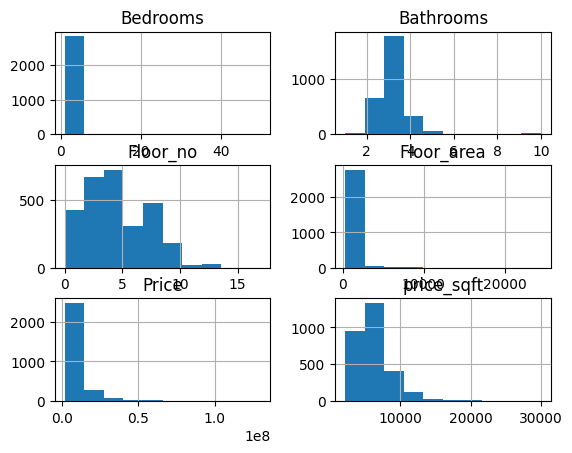

In [14]:
# check the distributions
df.hist()

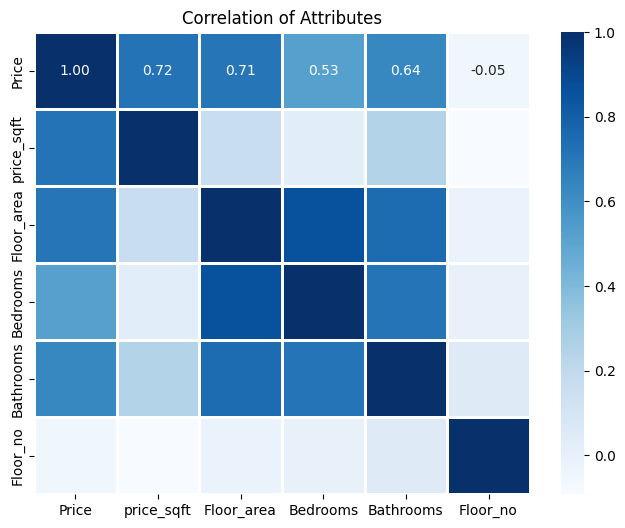

In [15]:
# Check for correlations
corr_df = df[['Price', 'price_sqft', 'Floor_area', 'Bedrooms', 'Bathrooms', 'Floor_no']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt = ".2f", cmap='Blues', linewidths = 0.8)
plt.title("Correlation of Attributes")
plt.show()


It seems that floor number has very little predictive correlation with price and can be included with columns to be dropped 

In [16]:
# Compute the Z-scores of each column
z_scores = stats.zscore(df[num_attribs])

# Identify the rows where the absolute Z-score is greater than a threshold of 3
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Drop outliers
df = df[filtered_entries].reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2768 non-null   object 
 1   Bedrooms          2768 non-null   float64
 2   Bathrooms         2768 non-null   float64
 3   Floor_no          2755 non-null   float64
 4   Occupancy_status  2768 non-null   object 
 5   Floor_area        2768 non-null   float64
 6   City              2768 non-null   object 
 7   Price             2768 non-null   int64  
 8   Location          2767 non-null   object 
 9   price_sqft        2768 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 216.4+ KB


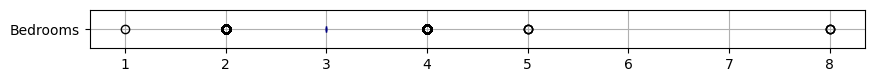

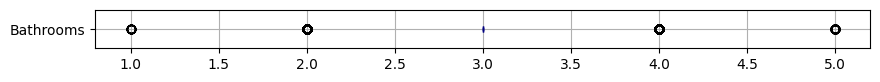

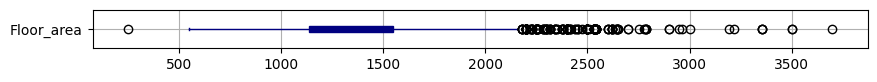

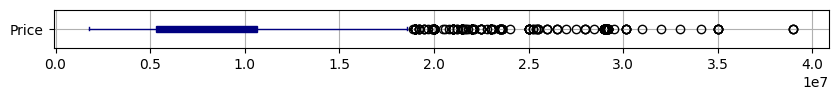

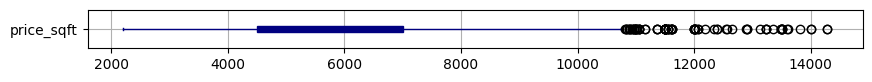

In [17]:
for feature in num_attribs:
    plt.figure(figsize=(10, 0.5))
    df.boxplot(column=feature, vert=False, patch_artist=True, color='navy')
    plt.show()

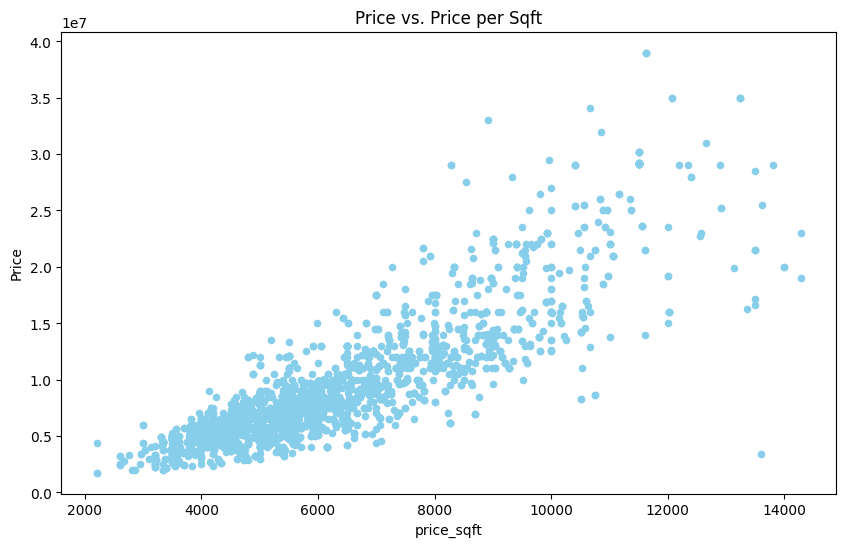

In [31]:
# After removing outliers, we should detect a linear correlation for price per square foot distribution    
df.plot(kind='scatter', x='price_sqft', y='Price', figsize=(10, 6), color='skyblue', title='Price vs. Price per Sqft')
plt.show()

## Building the Pipeline

In [18]:
df = df[['City', 'Price', 'price_sqft', 'Floor_area', 'Bedrooms', 'Bathrooms']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        2768 non-null   object 
 1   Price       2768 non-null   int64  
 2   price_sqft  2768 non-null   float64
 3   Floor_area  2768 non-null   float64
 4   Bedrooms    2768 non-null   float64
 5   Bathrooms   2768 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 129.9+ KB


In [19]:
# Split the data
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
numerical_cols = ['price_sqft', 'Floor_area', 'Bedrooms', 'Bathrooms']
categorical_cols = ['City']

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['price_sqft', 'Floor_area', 'Bedrooms',
                                  'Bathrooms']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['City'])])

In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'XGBoost' : XGBRegressor()
}

In [29]:
results = {}
for model_name, model in models.items():
    
    pipeline = Pipeline([('preprocessing', preprocessing), ('model', model)])
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    execution_time = round(time.time() - start_time, 4)

    preds = pipeline.predict(X_test)
    mae = round(mean_absolute_error(y_test, preds), 0)
    r2 = round(r2_score(y_test, preds), 3)
    
    # Store the results, including execution time
    results[model_name] = {'Execution Time': execution_time, 'MAE': mae, 'R2 Score': r2}

# Print the results for each model
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"Execution Time: {metrics['Execution Time']} seconds")
    print(f"   Mean Absolute Error: {metrics['MAE']}")
    print(f"   R2 Score: {metrics['R2 Score']}")
    print('--------------------------------------')


Linear Regression:
Execution Time: 0.0113 seconds
   Mean Absolute Error: 635578.0
   R2 Score: 0.97
--------------------------------------
Ridge Regression:
Execution Time: 0.0057 seconds
   Mean Absolute Error: 634882.0
   R2 Score: 0.97
--------------------------------------
Lasso Regression:
Execution Time: 0.0393 seconds
   Mean Absolute Error: 635577.0
   R2 Score: 0.97
--------------------------------------
Random Forest:
Execution Time: 0.6602 seconds
   Mean Absolute Error: 68579.0
   R2 Score: 0.999
--------------------------------------
Gradient Boosting:
Execution Time: 0.1874 seconds
   Mean Absolute Error: 176746.0
   R2 Score: 0.998
--------------------------------------
Support Vector Regressor:
Execution Time: 0.1276 seconds
   Mean Absolute Error: 3525450.0
   R2 Score: -0.091
--------------------------------------
XGBoost:
Execution Time: 0.0554 seconds
   Mean Absolute Error: 76193.0
   R2 Score: 0.999
--------------------------------------


### Conclusion

In conclusion, the XGBoost model appears to perform best with the dataset after Null values and outliers are dropped.  Please note that the purpose of this exercise is to demonstrate the pipeline, and the very high R2 scores indicates that the model is overfitted to the data.  For a business solution, it is anticipated that the analyst applying different outlier and null value criteria to capture the greatest number of valid datapoints befroe concluding which model would be appropriate and if regression models can outperform classification models on the larger dataset when using bedrooms/bathrooms/floor area as categorical attributes.